## 1. Data Preparation

### 1.1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import time

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV , KFold
from sklearn.metrics import mean_squared_error 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge , ElasticNet , Lasso
from sklearn.ensemble import RandomForestRegressor  , AdaBoostRegressor 
from sklearn.preprocessing import MinMaxScaler

- Import data, check for comlumns and variables
### 1.2. Load and Clean Data
Load the dataset, inspect its structure, and perform initial cleaning. We drop the original 'Price' column (in Toman) and use 'Price(USD)' for our analysis, renaming it to 'Price'.

In [2]:
houses = pd.read_csv("data/housePrice.csv")
houses = houses.drop('Price', axis=1)
houses = houses.rename(columns={'Price(USD)': 'Price'})
houses.info()
houses.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3474 entries, 0 to 3473
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       3474 non-null   object 
 1   Room       3474 non-null   int64  
 2   Parking    3474 non-null   bool   
 3   Warehouse  3474 non-null   bool   
 4   Elevator   3474 non-null   bool   
 5   Address    3451 non-null   object 
 6   Price      3474 non-null   float64
dtypes: bool(3), float64(1), int64(1), object(2)
memory usage: 118.9+ KB


,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,420,4,True,True,True,Zaferanieh,3080000.00
1,705,5,True,True,False,Abazar,3033333.33
2,400,5,True,True,False,Lavasan,2833333.33
3,680,5,True,True,False,Ekhtiarieh,2720000.00
4,350,4,True,True,True,Niavaran,2683333.33


- Since the Address column has some missing data in certain rows, we will drop these rows.

In [3]:
houses = houses.dropna(subset=['Address'])

- Check the header again

In [4]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3451 entries, 0 to 3473
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       3451 non-null   object 
 1   Room       3451 non-null   int64  
 2   Parking    3451 non-null   bool   
 3   Warehouse  3451 non-null   bool   
 4   Elevator   3451 non-null   bool   
 5   Address    3451 non-null   object 
 6   Price      3451 non-null   float64
dtypes: bool(3), float64(1), int64(1), object(2)
memory usage: 144.9+ KB


- Check the correlation between variables and the price variable before converting them into categories (actually this is feature engineering xD)

In [5]:
# houses['Price'] = np.log1p(houses['Price'])
# houses['Area'] = np.log1p(pd.to_numeric(houses['Area'], errors='coerce'))
houses['Area'] = pd.to_numeric(houses['Area'], errors='coerce')
houses = houses.dropna(subset=['Area'])
houses['Room'] = houses['Room'].astype('int64')
houses['Area_per_Room'] = houses['Area'] / (houses['Room']+1)
houses['Area_per_Room'] = houses['Area_per_Room'].replace([np.inf, -np.inf], np.nan)
address_avg_price = houses.groupby('Address')['Price'].mean()
#houses['Avg_Price_by_Address'] = houses['Address'].map(address_avg_price)
houses['Price_per_m2'] = houses['Price'] / houses['Area']
houses['Price_per_room'] = houses['Price'] / (houses['Room'] + 1)
address_avg_price_per_m2 = houses.groupby('Address')['Price_per_m2'].mean()
# houses['Avg_Price_per_m2_by_Address'] = houses['Address'].map(address_avg_price_per_m2)
houses = houses.drop('Price_per_m2', axis=1)

# houses['Parking_Warehouse'] = (houses['Parking'] == True) & (houses['Warehouse'] == True)
# houses['Parking_Elevator'] = (houses['Parking'] == True) & (houses['Elevator'] == True)
# houses['Elevator_Warehouse'] = (houses['Elevator'] == True) & (houses['Warehouse'] == True)
# houses['All_Amenities'] = (houses['Parking'] == True) & (houses['Warehouse'] == True) & (houses['Elevator'] == True)

numeric_houses = houses.select_dtypes(include=[np.number, bool]) 
corr_matrix = numeric_houses.corr()
corr_matrix["Price"].sort_values(ascending=False)

Price             1.000000
Price_per_room    0.864598
Area              0.722864
Room              0.567802
Area_per_Room     0.522454
Parking           0.190935
Elevator          0.111443
Warehouse         0.109224
Name: Price, dtype: float64

In [ ]:
# Create a ranking feature based on area prestige levels
def create_area_ranking(houses):
    # Define area rankings
    area_rankings = {
        1: ['Baghestan', 'Chardivari', 'Firoozkooh', 'Golestan', 'Pakdasht', 'Parand', 'Pishva', 
            'Qarchak', 'Railway', 'Robat Karim', 'SabaShahr', 'Safadasht', 'Salehabad', 
            'Shahedshahr', 'Shoosh', 'Varamin', 'Yaftabad'],
        
        2: ['Aliabad South', 'Amir Bahador', 'Amirieh', 'Andisheh', 'Atabak', 'Azarbaijan', 
            'Azari', 'Baqershahr', 'Beryanak', 'Boloorsazi', 'Chahardangeh', 'Dolatabad', 
            'Eskandari', 'Fallah', 'Ghiyamdasht', 'Hassan Abad', 'Islamshahr', 'Javadiyeh', 
            'Jeyhoon', 'Kahrizak', 'Karoon', 'Khademabad Garden', 'Khavaran', 'Komeil', 
            'Moniriyeh', 'Nasim Shahr', 'Nawab', 'Naziabad', 'Nezamabad', 'Ostad Moein', 
            'Qazvin Imamzadeh Hassan', 'Ray', 'Rudhen', 'Sabalan', 'Salsabil', 'Shadabad', 
            'Shahryar', 'Si Metri Ji', 'Tarasht', 'Tehran Now', 'Tehransar', 'Vahidieh', 
            'Yakhchiabad'],
        
        3: ['Abuzar', 'Afsarieh', 'Ahang', 'Air force', 'Alborz Complex', 'Amirabad', 
            'Azadshahr', 'Bahar', 'Central Janatabad', 'Damavand', 'Daryan No', 
            'Dehkade Olampic', 'East Pars', 'Ekbatan', 'Elm-o-Sanat', 'Enghelab', 'Eram', 
            'Feiz Garden', 'Garden of Saba', 'Gisha', 'Haft Tir', 'Hakimiyeh', 'Heshmatieh', 
            'Hor Square', 'Islamshahr Elahieh', 'Kazemabad', 'Koohsar', 'Majidieh', 
            'Marzdaran', 'Narmak', 'Northren Jamalzadeh', 'Parastar', 'Pardis', 'Pirouzi', 
            'Punak', 'Qasr-od-Dasht', 'Republic', 'Sadeghieh', 'Sattarkhan', 'Shahr-e-Ziba', 
            'ShahrAra', 'Shahrake Apadana', 'Shahrake Azadi', 'Shahran', 'Shams Abad', 
            'Southern Chitgar', 'Southern Janatabad', 'Southern Program Organization', 
            'Southern Suhrawardi', 'Taslihat', 'Telecommunication', 'Water Organization'],
        
        4: ['Abbasabad', 'Absard', 'Ajudaniye', 'Aqdasieh', 'Araj', 'Argentina', 'Darabad', 
            'Darakeh', 'Dezashib', 'Dorous', 'East Ferdows Boulevard', 'Ekhtiarieh', 'Fatemi', 
            'Gheitarieh', 'Ghoba', 'Gholhak', 'Hekmat', 'Heravi', 'Jordan', 'Karimkhan', 
            'Keshavarz Boulevard', 'Lavizan', 'Mirdamad', 'Mirza Shirazi', 'North Program Organization', 
            'Northern Chitgar', 'Northern Suhrawardi', 'Ozgol', 'Pasdaran', 'Persian Gulf Martyrs Lake', 
            'Qalandari', 'Saadat Abad', 'Seyed Khandan', 'Shahrake Gharb', 'Shahrake Shahid Bagheri', 
            'Shahrakeh Naft', 'Sohanak', 'Thirteen November', 'Vanak', 'Villa', 'Waterfall', 
            'West Ferdows Boulevard', 'West Pars', 'Yousef Abad', 'Zafar', 'Zargandeh', 'Zibadasht'],
        
        5: ['Darband', 'Elahieh', 'Farmanieh', 'Kamranieh', 'Mahmoudieh', 'Niavaran', 
            'Velenjak', 'Zaferanieh']
    }
    
    # Create a mapping from area name to ranking
    area_to_ranking = {}
    for ranking, areas in area_rankings.items():
        for area in areas:
            area_to_ranking[area] = ranking
    
    # Initialize ranking column with default value 3
    houses['Area_Ranking'] = 3
    
    # Find address columns and map rankings
    address_cols = [col for col in houses.columns if col.startswith('Address_')]
    
    for addr_col in address_cols:
        area_name = addr_col.replace('Address_', '')
        if area_name in area_to_ranking:
            # Set ranking for houses in this area
            houses.loc[houses[addr_col] == 1, 'Area_Ranking'] = area_to_ranking[area_name]
    
    return houses

# Apply the ranking feature
houses = create_area_ranking(houses)

# Display summary of the new ranking feature
print("Area Ranking Summary:")
print("=" * 40)
ranking_counts = houses['Area_Ranking'].value_counts().sort_index()
for ranking, count in ranking_counts.items():
    percentage = count / len(houses) * 100
    print(f"Ranking {ranking}: {count:4d} houses ({percentage:5.1f}%)")

print(f"\nTotal houses: {len(houses)}")
print(f"New feature 'Area_Ranking' added successfully!")

# Show correlation with price
correlation = houses[['Area_Ranking', 'Price']].corr()
print(f"\nCorrelation between Area_Ranking and Price: {correlation.iloc[0,1]:.4f}")

# Display first few rows to verify
print(f"\nFirst 5 rows with new ranking:")
print(houses[['Area', 'Room', 'Price', 'Area_Ranking']].head())

Area Ranking Summary:
Ranking 3: 3449 houses (100.0%)

Total houses: 3449
New feature 'Area_Ranking' added successfully!

Correlation between Area_Ranking and Price: nan

First 5 rows with new ranking:
    Area  Room       Price  Area_Ranking
0  420.0     4  3080000.00             3
1  705.0     5  3033333.33             3
2  400.0     5  2833333.33             3
3  680.0     5  2720000.00             3
4  350.0     4  2683333.33             3


- That said, the data is now complete. HOWEVER, we have not yet categorized the data into the two main types: Numerical and Categorical. Now, we will do that.

In [7]:
# Convert specified columns to categorical data type
houses['Room'] = houses['Room'].astype('category')
houses['Parking'] = houses['Parking'].astype('category')
houses['Warehouse'] = houses['Warehouse'].astype('category')
houses['Elevator'] = houses['Elevator'].astype('category')
# Verify the changes
print("Data types after conversion:")
print(houses.dtypes)
houses.info()

Data types after conversion:
Area               float64
Room              category
Parking           category
Warehouse         category
Elevator          category
Address             object
Price              float64
Area_per_Room      float64
Price_per_room     float64
Area_Ranking         int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 3449 entries, 0 to 3473
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Area            3449 non-null   float64 
 1   Room            3449 non-null   category
 2   Parking         3449 non-null   category
 3   Warehouse       3449 non-null   category
 4   Elevator        3449 non-null   category
 5   Address         3449 non-null   object  
 6   Price           3449 non-null   float64 
 7   Area_per_Room   3449 non-null   float64 
 8   Price_per_room  3449 non-null   float64 
 9   Area_Ranking    3449 non-null   int64   
dtypes: category(4), float64(4), 

### 1.3. Outlier Removal
To prevent extreme values from skewing the analysis, we remove the top and bottom 1% of properties based on price.

In [8]:
# Calculate 1st and 99th percentiles
lower_percentile = houses['Price'].quantile(0.01)
upper_percentile = houses['Price'].quantile(0.95) # !!

price_min = lower_percentile
price_max = upper_percentile

print(price_max, price_min)

print(f"1st percentile (1% lowest): ${lower_percentile:.2f}")
print(f"99th percentile (1% highest): ${upper_percentile:.2f}")

# Remove outliers
houses_before = len(houses)
houses = houses[(houses['Price'] >= lower_percentile) & (houses['Price'] <= upper_percentile)]
houses_after = len(houses)

print(f"\nDataset size before removing outliers: {houses_before}")
print(f"Dataset size after removing outliers: {houses_after}")
print(f"Removed {houses_before - houses_after} outliers ({((houses_before - houses_after) / houses_before * 100):.1f}%)")

595626.667999999 9865.3316
1st percentile (1% lowest): $9865.33
99th percentile (1% highest): $595626.67

Dataset size before removing outliers: 3449
Dataset size after removing outliers: 3241
Removed 208 outliers (6.0%)


## 2. Data Preparation


- first 10 rows

In [9]:
houses.head(10)

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Area_per_Room,Price_per_room,Area_Ranking
173,188.0,3,True,True,True,Ozgol,589066.67,47.00,147266.667500,3
174,165.0,3,True,True,True,Niavaran,588500.00,41.25,147125.000000,3
175,160.0,3,True,True,True,Farmanieh,586666.67,40.00,146666.667500,3
176,135.0,2,True,True,True,Zaferanieh,583333.33,45.00,194444.443333,3
177,160.0,3,True,True,True,Niavaran,583333.33,40.00,145833.332500,3
178,175.0,3,True,True,True,Elahieh,583333.33,43.75,145833.332500,3
179,195.0,3,True,True,True,Farmanieh,576000.00,48.75,144000.000000,3
180,138.0,2,True,True,True,Zaferanieh,575000.00,46.00,191666.666667,3
181,165.0,3,True,True,True,Niavaran,573333.33,41.25,143333.332500,3
182,155.0,3,True,True,True,Niavaran,568333.33,38.75,142083.332500,3


- This part was already carried out in quite detail in the file `houses_price.ipynb`; you can refer to that notebook for more information.

- One-hot encoding

In [10]:
# One-hot encoding for Address column
address_encoded = pd.get_dummies(houses['Address'], prefix='Address')

# Concatenate the one-hot encoded columns with the original dataframe
houses_encoded = pd.concat([houses, address_encoded], axis=1)

# Drop the original Address column since we now have encoded versions
houses_encoded = houses_encoded.drop('Address', axis=1)

print(f"Original dataset shape: {houses.shape}")
print(f"Dataset shape after one-hot encoding: {houses_encoded.shape}")
print(f"Added {address_encoded.shape[1]} new columns for Address categories")

# Display the new column names
print(f"\nNew Address columns created:")
print(list(address_encoded.columns))

# Update our main dataframe
houses = houses_encoded
houses.head()

Original dataset shape: (3241, 10)
Dataset shape after one-hot encoding: (3241, 198)
Added 189 new columns for Address categories

New Address columns created:
['Address_Abazar', 'Address_Abbasabad', 'Address_Absard', 'Address_Abuzar', 'Address_Afsarieh', 'Address_Ahang', 'Address_Air force', 'Address_Ajudaniye', 'Address_Alborz Complex', 'Address_Aliabad South', 'Address_Amir Bahador', 'Address_Amirabad', 'Address_Amirieh', 'Address_Andisheh', 'Address_Aqdasieh', 'Address_Araj', 'Address_Argentina', 'Address_Atabak', 'Address_Azadshahr', 'Address_Azarbaijan', 'Address_Azari', 'Address_Baghestan', 'Address_Bahar', 'Address_Baqershahr', 'Address_Beryanak', 'Address_Boloorsazi', 'Address_Central Janatabad', 'Address_Chahardangeh', 'Address_Chardangeh', 'Address_Chardivari', 'Address_Chidz', 'Address_Damavand', 'Address_Darabad', 'Address_Darakeh', 'Address_Darband', 'Address_Daryan No', 'Address_Dehkade Olampic', 'Address_Dezashib', 'Address_Dolatabad', 'Address_Dorous', 'Address_East Fe

,Area,Room,Parking,Warehouse,Elevator,Price,Area_per_Room,Price_per_room,Area_Ranking,Address_Abazar,...,Address_Waterfall,Address_West Ferdows Boulevard,Address_West Pars,Address_Yaftabad,Address_Yakhchiabad,Address_Yousef Abad,Address_Zafar,Address_Zaferanieh,Address_Zargandeh,Address_Zibadasht
173,188.0,3,True,True,True,589066.67,47.00,147266.667500,3,False,...,False,False,False,False,False,False,False,False,False,False
174,165.0,3,True,True,True,588500.00,41.25,147125.000000,3,False,...,False,False,False,False,False,False,False,False,False,False
175,160.0,3,True,True,True,586666.67,40.00,146666.667500,3,False,...,False,False,False,False,False,False,False,False,False,False
176,135.0,2,True,True,True,583333.33,45.00,194444.443333,3,False,...,False,False,False,False,False,False,False,True,False,False
177,160.0,3,True,True,True,583333.33,40.00,145833.332500,3,False,...,False,False,False,False,False,False,False,False,False,False


- Transform cols

In [11]:

X = houses.drop('Price', axis=1)  
y = houses['Price']              
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns:")
print(list(X.columns))


X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,     
    random_state=42     
)

scaler_X = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

scaler_y = MinMaxScaler()

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

y_train_scaled = scaler_y.fit_transform(y_train_reshaped)

y_test_scaled = scaler_y.transform(y_test_reshaped)

y_train = pd.Series(y_train_scaled.flatten(), name=y_train.name, index=y_train.index)
y_test = pd.Series(y_test_scaled.flatten(), name=y_test.name, index=y_test.index)

X_train.head()

Features shape: (3241, 197)
Target shape: (3241,)

Feature columns:
['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Area_per_Room', 'Price_per_room', 'Area_Ranking', 'Address_Abazar', 'Address_Abbasabad', 'Address_Absard', 'Address_Abuzar', 'Address_Afsarieh', 'Address_Ahang', 'Address_Air force', 'Address_Ajudaniye', 'Address_Alborz Complex', 'Address_Aliabad South', 'Address_Amir Bahador', 'Address_Amirabad', 'Address_Amirieh', 'Address_Andisheh', 'Address_Aqdasieh', 'Address_Araj', 'Address_Argentina', 'Address_Atabak', 'Address_Azadshahr', 'Address_Azarbaijan', 'Address_Azari', 'Address_Baghestan', 'Address_Bahar', 'Address_Baqershahr', 'Address_Beryanak', 'Address_Boloorsazi', 'Address_Central Janatabad', 'Address_Chahardangeh', 'Address_Chardangeh', 'Address_Chardivari', 'Address_Chidz', 'Address_Damavand', 'Address_Darabad', 'Address_Darakeh', 'Address_Darband', 'Address_Daryan No', 'Address_Dehkade Olampic', 'Address_Dezashib', 'Address_Dolatabad', 'Address_Dorous', 'Addr

,Area,Room,Parking,Warehouse,Elevator,Area_per_Room,Price_per_room,Area_Ranking,Address_Abazar,Address_Abbasabad,...,Address_Waterfall,Address_West Ferdows Boulevard,Address_West Pars,Address_Yaftabad,Address_Yakhchiabad,Address_Yousef Abad,Address_Zafar,Address_Zaferanieh,Address_Zargandeh,Address_Zibadasht
3130,0.062069,0.4,1.0,1.0,1.0,0.054612,0.025069,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1016,0.137931,0.6,1.0,1.0,1.0,0.089199,0.207361,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1353,0.068966,0.4,1.0,1.0,1.0,0.061893,0.203014,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1800,0.043678,0.4,1.0,1.0,1.0,0.035194,0.142153,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2847,0.043678,0.4,0.0,1.0,1.0,0.035194,0.043617,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Model training

- Split into test_set and train_set

In [12]:

print(f"\nTraining set:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"\nTesting set:")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"\nData split summary:")
print(f"Total samples: {len(houses)}")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(houses)*100:.1f}%)")
print(f"Testing samples: {len(X_test)} ({len(X_test)/len(houses)*100:.1f}%)")


Training set:
X_train shape: (2592, 197)
y_train shape: (2592,)

Testing set:
X_test shape: (649, 197)
y_test shape: (649,)

Data split summary:
Total samples: 3241
Training samples: 2592 (80.0%)
Testing samples: 649 (20.0%)


- try with models

- just convert function

In [13]:
price_min = scaler_y.data_min_[0]
price_max = scaler_y.data_max_[0]
def convert_scaled_to_original_price(scaled_value, price_min=None, price_max=None):
    """
    Convert scaled price value back to original USD price
    
    Parameters:
    scaled_value: float (0-1) - giá trị đã được MinMaxScaler
    price_min: float - giá trị min của Price sau khi log1p 
    price_max: float - giá trị max của Price sau khi log1p 
    
    Returns:
    float - giá trị USD gốc
    """
    
    # Bước 1: Unscale từ [0,1] về log scale
    log_price = scaled_value * (price_max - price_min) + price_min
    
    # Bước 2: Inverse log transform (expm1 là ngược lại của log1p)
    # original_price = np.expm1(log_price)
    original_price = log_price
    
    return original_price


In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import pandas as pd

models = {
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'ElasticNet': ElasticNet(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'K-Neighbors': KNeighborsRegressor(),
    'AdaBoost': AdaBoostRegressor(random_state=42)
}

# Store results
results = {}

print("Running K-Fold Cross Validation (k=10) for each model...")
print("=" * 60)

# Test each model with k-fold cross validation
for model_name, model in models.items():
    print(f"\nTesting {model_name}...")
    
    # Perform 10-fold cross validation
    # Using neg_root_mean_squared_error (negative RMSE)
    cv_scores = -cross_val_score(
        model, X_train, y_train,
        scoring="neg_root_mean_squared_error",
        cv=10,
        n_jobs=-1  # Use all available processors
    )
    
    # Store results
    results[model_name] = cv_scores
    
    # Display statistics
    score_stats = pd.Series(cv_scores).describe()
    print(f"Cross-validation RMSE scores for {model_name}:")
    print(score_stats)
    print(f"Mean RMSE: {cv_scores.mean():.6f} (+/- {cv_scores.std() * 2:.6f})")
    
    # Convert to original USD
    mean_rmse_usd = convert_scaled_to_original_price(cv_scores.mean(), price_min, price_max)
    print(f"Mean RMSE in original USD: ${mean_rmse_usd:,.2f}")

print("\n" + "=" * 60)
print("SUMMARY OF ALL MODELS")
print("=" * 60)

# Create summary comparison
summary_data = []
for model_name, scores in results.items():
    mean_rmse = scores.mean()
    mean_rmse_usd = convert_scaled_to_original_price(mean_rmse, price_min, price_max)
    
    summary_data.append({
        'Model': model_name,
        'Mean RMSE': mean_rmse,
        'Mean RMSE (USD)': mean_rmse_usd,
        'Std RMSE': scores.std(),
        'Min RMSE': scores.min(),
        'Max RMSE': scores.max()
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Mean RMSE')

# Format the USD column for better display
summary_df_display = summary_df.copy()
summary_df_display['Mean RMSE (USD)'] = summary_df_display['Mean RMSE (USD)'].apply(lambda x: f"${x:,.2f}")

print(summary_df_display[['Model', 'Mean RMSE', 'Mean RMSE (USD)', 'Std RMSE']].to_string(index=False))

# Find the best model
best_model_name = summary_df.iloc[0]['Model']
best_rmse = summary_df.iloc[0]['Mean RMSE']
best_rmse_usd = summary_df.iloc[0]['Mean RMSE (USD)']

print(f"\nBest performing model: {best_model_name}")
print(f"Best RMSE: {best_rmse:.6f}")
print(f"Best RMSE in original USD: ${best_rmse_usd:,.2f}")

Running K-Fold Cross Validation (k=10) for each model...

Testing Ridge Regression...
Cross-validation RMSE scores for Ridge Regression:
count    10.000000
mean      0.035346
std       0.005173
min       0.027075
25%       0.032116
50%       0.035242
75%       0.038726
max       0.043237
dtype: float64
Mean RMSE: 0.035346 (+/- 0.009816)
Mean RMSE in original USD: $30,351.29

Testing Lasso Regression...
Cross-validation RMSE scores for Lasso Regression:
count    10.000000
mean      0.204320
std       0.016075
min       0.173723
25%       0.200877
50%       0.206147
75%       0.208556
max       0.235931
dtype: float64
Mean RMSE: 0.204320 (+/- 0.030500)
Mean RMSE in original USD: $128,119.29

Testing ElasticNet...
Cross-validation RMSE scores for ElasticNet:
count    10.000000
mean      0.204320
std       0.016075
min       0.173723
25%       0.200877
50%       0.206147
75%       0.208556
max       0.235931
dtype: float64
Mean RMSE: 0.204320 (+/- 0.030500)
Mean RMSE in original USD: $128,

In [15]:
best_model = RandomForestRegressor(random_state=42)
best_model.fit(X_train, y_train)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

rmse_train_usd = convert_scaled_to_original_price(rmse_train, price_min, price_max)
rmse_test_usd = convert_scaled_to_original_price(rmse_test, price_min, price_max)

print("Random Forest Model Performance:")
print("=" * 50)
print(f"Training Set:")
print(f"  R² Score: {r2_train:.6f}")
print(f"  RMSE: {rmse_train:.6f}")
print(f"  RMSE (USD): ${rmse_train_usd:,.2f}")

print(f"\nTest Set:")
print(f"  R² Score: {r2_test:.6f}")
print(f"  RMSE: {rmse_test:.6f}")
print(f"  RMSE (USD): ${rmse_test_usd:,.2f}")

print(f"\nModel Comparison:")
print(f"  Difference in R² (Train - Test): {r2_train - r2_test:.6f}")
print(f"  Difference in RMSE (Test - Train): {rmse_test - rmse_train:.6f}")

if r2_train - r2_test > 0.1:
    print("Potential overfitting detected (R² difference > 0.1)")
else:
    print("Good generalization performance")

Random Forest Model Performance:
Training Set:
  R² Score: 0.999485
  RMSE: 0.004645
  RMSE (USD): $12,587.61

Test Set:
  R² Score: 0.998302
  RMSE: 0.009140
  RMSE (USD): $15,188.20

Model Comparison:
  Difference in R² (Train - Test): 0.001183
  Difference in RMSE (Test - Train): 0.004495
Good generalization performance


In [16]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

# Define parameter grid for GridSearchCV (reduced ranges for computational efficiency)
param_grid = {
    'n_estimators': [200],
    'max_features': ['log2'],
    'max_depth': [None],
    'min_samples_split': [10],
    'min_samples_leaf': [1],
    'bootstrap': [False]
}

# Calculate total combinations
total_combinations = 1
for param, values in param_grid.items():
    total_combinations *= len(values)
print(f"Total parameter combinations to test: {total_combinations:,}")
print(f"With 5-fold CV, total fits: {total_combinations * 5:,}")

# Create GridSearchCV
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,        # 5-fold cross validation
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,   # Use all available processors
    verbose=1    # Show progress
)

print("Starting Grid Search CV...")
print("This will test ALL parameter combinations - may take a while...")
start_time = time.time()

# Fit the grid search
grid_search.fit(X_train, y_train)

end_time = time.time()
print(f"Grid Search completed in {end_time - start_time:.2f} seconds")
print(f"Time per combination: {(end_time - start_time) / total_combinations:.2f} seconds")

# Get the best parameters and score
print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"\nBest cross-validation RMSE: {-grid_search.best_score_:.6f}")
print(f"Best RMSE in USD: ${convert_scaled_to_original_price(-grid_search.best_score_, price_min, price_max):,.2f}")

# Train the best model on full training set and evaluate
best_rf_model = grid_search.best_estimator_
y_train_pred_best = best_rf_model.predict(X_train)
y_test_pred_best = best_rf_model.predict(X_test)

# Calculate performance metrics
r2_train_best = r2_score(y_train, y_train_pred_best)
r2_test_best = r2_score(y_test, y_test_pred_best)
rmse_train_best = np.sqrt(mean_squared_error(y_train, y_train_pred_best))
rmse_test_best = np.sqrt(mean_squared_error(y_test, y_test_pred_best))

print(f"\nOptimized Random Forest Performance:")
print(f"Training R²: {r2_train_best:.6f}")
print(f"Test R²: {r2_test_best:.6f}")
print(f"Training RMSE: {rmse_train_best:.6f} (${convert_scaled_to_original_price(rmse_train_best, price_min, price_max):,.2f})")
print(f"Test RMSE: {rmse_test_best:.6f} (${convert_scaled_to_original_price(rmse_test_best, price_min, price_max):,.2f})")

# Compare with original model
print(f"\nComparison with original Random Forest:")
print(f"Original Test RMSE: {rmse_test:.6f} vs Optimized: {rmse_test_best:.6f}")
print(f"Improvement: {((rmse_test - rmse_test_best) / rmse_test * 100):.2f}%")

# Show top 10 parameter combinations
print(f"\nTop 10 parameter combinations:")
print("="*80)
results_df = pd.DataFrame(grid_search.cv_results_)
top_10 = results_df.nlargest(10, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
for i, (idx, row) in enumerate(top_10.iterrows(), 1):
    rmse = -row['mean_test_score']
    rmse_usd = convert_scaled_to_original_price(rmse, price_min, price_max)
    print(f"{i:2d}. RMSE: {rmse:.6f} (${rmse_usd:,.0f}) | {row['params']}")

Total parameter combinations to test: 1
With 5-fold CV, total fits: 5
Starting Grid Search CV...
This will test ALL parameter combinations - may take a while...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


Grid Search completed in 2.85 seconds
Time per combination: 2.85 seconds

Best parameters found:
{'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}

Best cross-validation RMSE: 0.043117
Best RMSE in USD: $34,847.47

Optimized Random Forest Performance:
Training R²: 0.987051
Test R²: 0.955369
Training RMSE: 0.023303 ($23,383.06)
Test RMSE: 0.046862 ($37,014.60)

Comparison with original Random Forest:
Original Test RMSE: 0.009140 vs Optimized: 0.046862
Improvement: -412.74%

Top 10 parameter combinations:
 1. RMSE: 0.043117 ($34,847) | {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


## 4. EDA test

9900.0
588500.0
Sample of original prices:
[ 52666.67 116666.67  40833.33 313333.33  26333.33]

Sample of predicted prices:
[ 53140.37051218 107207.29317724  53491.18690044 308404.32109821
  28958.70108056]
Total test samples: 649
Predictions with error > 20%: 105 (16.2%)
Mean percentage error: 14.57%
Median percentage error: 6.18%


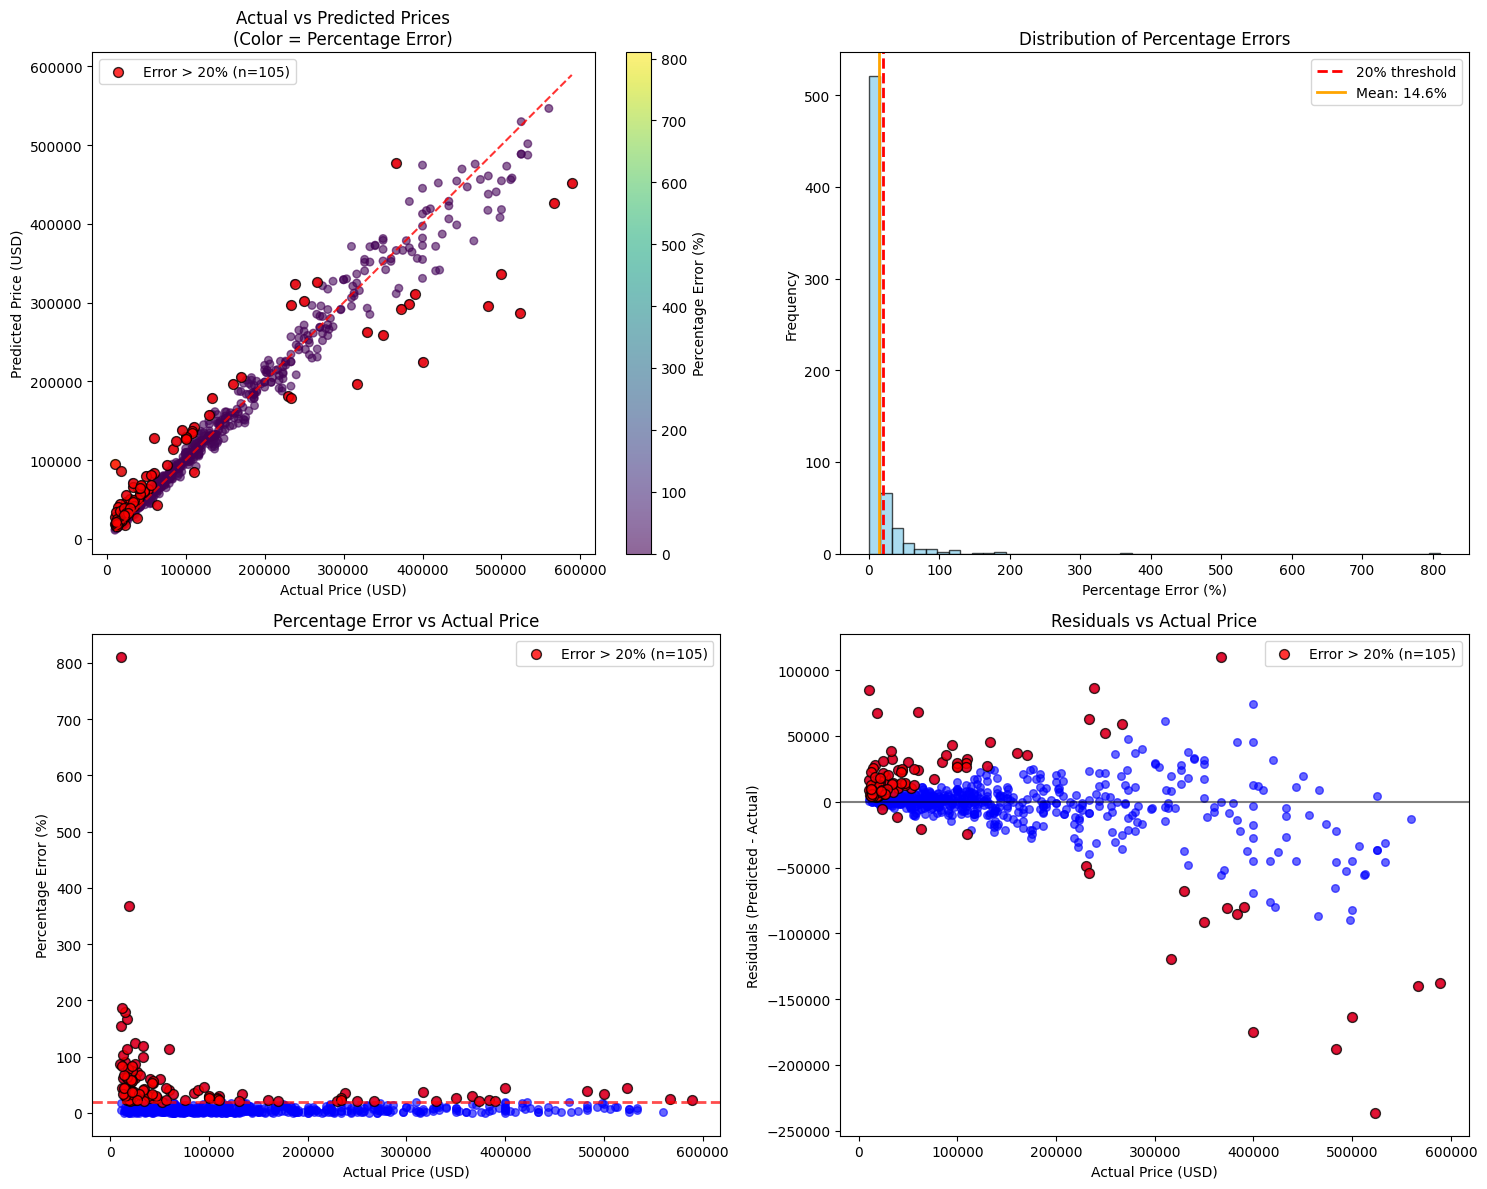


Top 10 worst predictions (highest percentage errors):
 1. Actual: $  10,500 | Predicted: $  95,582 | Error: 810.3%
 2. Actual: $  18,333 | Predicted: $  85,825 | Error: 368.1%
 3. Actual: $  12,000 | Predicted: $  34,461 | Error: 187.2%
 4. Actual: $  14,500 | Predicted: $  40,427 | Error: 178.8%
 5. Actual: $  16,667 | Predicted: $  44,388 | Error: 166.3%
 6. Actual: $  10,667 | Predicted: $  27,240 | Error: 155.4%
 7. Actual: $  25,000 | Predicted: $  55,936 | Error: 123.7%
 8. Actual: $  32,667 | Predicted: $  71,414 | Error: 118.6%
 9. Actual: $  16,667 | Predicted: $  35,741 | Error: 114.4%
10. Actual: $  59,733 | Predicted: $ 127,557 | Error: 113.5%


In [17]:
print(price_min)
print(price_max)

# Calculate percentage errors for the optimized Random Forest model
y_test_original = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
y_test_pred_original = scaler_y.inverse_transform(y_test_pred_best.reshape(-1, 1)).flatten()

print("Sample of original prices:")
print(y_test_original[:5])
print("\nSample of predicted prices:")
print(y_test_pred_original[:5])

# Calculate percentage error
percentage_errors = np.abs((y_test_pred_original - y_test_original) / y_test_original) * 100

# Identify predictions with error > 20%
high_error_mask = percentage_errors > 20
high_error_indices = np.where(high_error_mask)[0]

print(f"Total test samples: {len(y_test)}")
print(f"Predictions with error > 20%: {np.sum(high_error_mask)} ({np.sum(high_error_mask)/len(y_test)*100:.1f}%)")
print(f"Mean percentage error: {percentage_errors.mean():.2f}%")
print(f"Median percentage error: {np.median(percentage_errors):.2f}%")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scatter plot: Actual vs Predicted prices
ax1 = axes[0, 0]
scatter = ax1.scatter(y_test_original, y_test_pred_original, 
                     c=percentage_errors, cmap='viridis', alpha=0.6, s=30)
ax1.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 'r--', alpha=0.8)
ax1.set_xlabel('Actual Price (USD)')
ax1.set_ylabel('Predicted Price (USD)')
ax1.set_title('Actual vs Predicted Prices\n(Color = Percentage Error)')
plt.colorbar(scatter, ax=ax1, label='Percentage Error (%)')

# Highlight high error points
high_error_actual = y_test_original[high_error_mask]
high_error_pred = y_test_pred_original[high_error_mask]
ax1.scatter(high_error_actual, high_error_pred, color='red', s=50, alpha=0.8, 
           edgecolors='black', linewidth=1, label=f'Error > 20% (n={len(high_error_actual)})')
ax1.legend()

# 2. Distribution of percentage errors
ax2 = axes[0, 1]
ax2.hist(percentage_errors, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(x=20, color='red', linestyle='--', linewidth=2, label='20% threshold')
ax2.axvline(x=percentage_errors.mean(), color='orange', linestyle='-', linewidth=2, 
           label=f'Mean: {percentage_errors.mean():.1f}%')
ax2.set_xlabel('Percentage Error (%)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Percentage Errors')
ax2.legend()

# 3. Error vs Actual Price
ax3 = axes[1, 0]
ax3.scatter(y_test_original, percentage_errors, alpha=0.6, s=30, color='blue')
ax3.scatter(y_test_original[high_error_mask], percentage_errors[high_error_mask], 
           color='red', s=50, alpha=0.8, edgecolors='black', linewidth=1,
           label=f'Error > 20% (n={np.sum(high_error_mask)})')
ax3.axhline(y=20, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax3.set_xlabel('Actual Price (USD)')
ax3.set_ylabel('Percentage Error (%)')
ax3.set_title('Percentage Error vs Actual Price')
ax3.legend()

# 4. Residuals plot
ax4 = axes[1, 1]
residuals = y_test_pred_original - y_test_original
ax4.scatter(y_test_original, residuals, alpha=0.6, s=30, color='blue')
ax4.scatter(y_test_original[high_error_mask], residuals[high_error_mask], 
           color='red', s=50, alpha=0.8, edgecolors='black', linewidth=1,
           label=f'Error > 20% (n={np.sum(high_error_mask)})')
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax4.set_xlabel('Actual Price (USD)')
ax4.set_ylabel('Residuals (Predicted - Actual)')
ax4.set_title('Residuals vs Actual Price')
ax4.legend()

plt.tight_layout()
plt.show()

# Show details of worst predictions
print(f"\nTop 10 worst predictions (highest percentage errors):")
print("="*80)
worst_indices = np.argsort(percentage_errors)[-10:][::-1]
for i, idx in enumerate(worst_indices, 1):
    actual = y_test_original[idx]
    predicted = y_test_pred_original[idx]
    error = percentage_errors[idx]
    print(f"{i:2d}. Actual: ${actual:8,.0f} | Predicted: ${predicted:8,.0f} | Error: {error:5.1f}%")

Feature Importance Analysis with Grouped Address Importance
Standard Feature Importance by Groups:
----------------------------------------
Numerical_Features: 0.3873 (38.7%)
Boolean_Amenities: 0.0449 (4.5%)
Address_Features: 0.2155 (21.5%)

Calculating Grouped Permutation Importance...
This may take a few minutes...



Grouped Permutation Importance Results:
Baseline R² Score: 0.9554

Numerical_Features:
  Importance: 0.2547 ± 0.0062
  Percentage: 71.6%
  Features count: 4

Address_Features:
  Importance: 0.0826 ± 0.0021
  Percentage: 23.2%
  Features count: 189

Boolean_Amenities:
  Importance: 0.0183 ± 0.0011
  Percentage: 5.1%
  Features count: 3



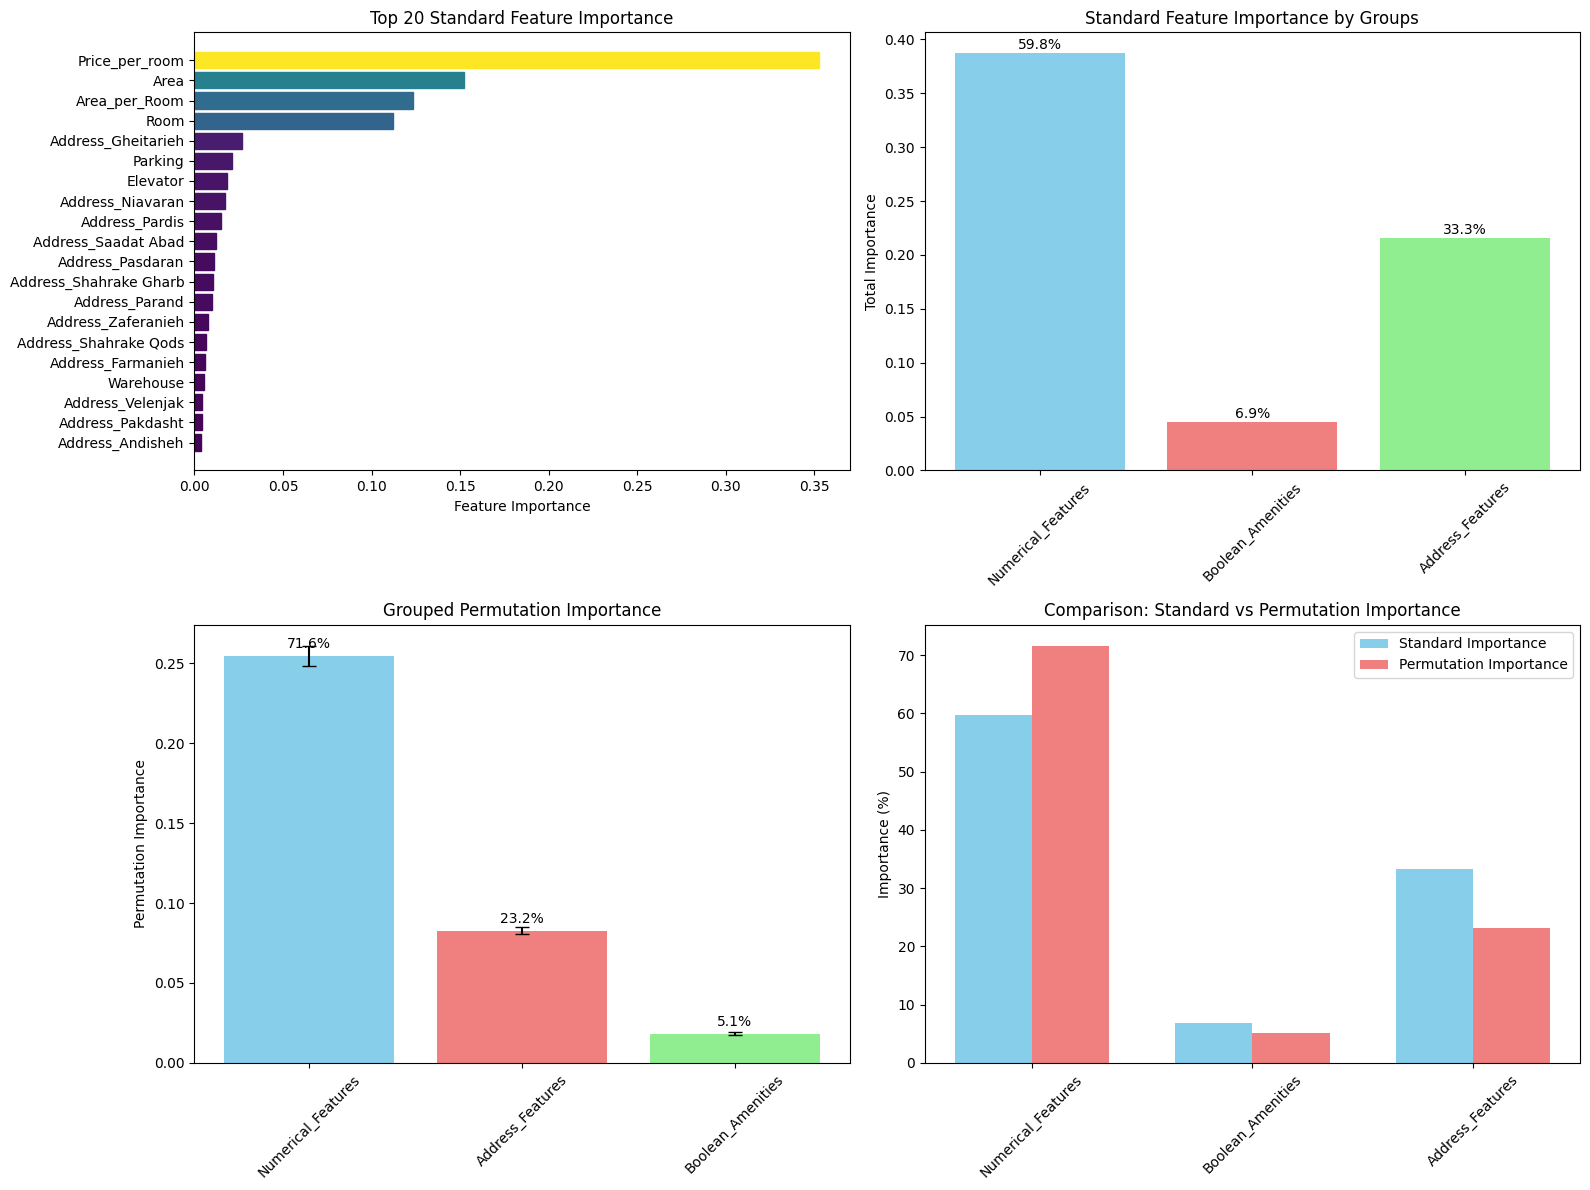


Top 10 Individual Address Features (Standard Importance):
-------------------------------------------------------
Gheitarieh                    : 0.0268
Niavaran                      : 0.0175
Pardis                        : 0.0150
Saadat Abad                   : 0.0121
Pasdaran                      : 0.0108
Shahrake Gharb                : 0.0104
Parand                        : 0.0101
Zaferanieh                    : 0.0074
Shahrake Qods                 : 0.0065
Farmanieh                     : 0.0059

SUMMARY:
Address Features Analysis:
  Number of address features: 189
  Standard importance (total): 0.2155 (21.5%)
  Permutation importance: 0.0826 (23.2%)
  Most important address: Gheitarieh


In [18]:
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# First, let's get the standard feature importance from the Random Forest
feature_importance = best_rf_model.feature_importances_
feature_names = X_train.columns

# Create a dataframe for easier manipulation
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Feature Importance Analysis with Grouped Address Importance")
print("=" * 60)

# Group features by category
feature_groups = {
    'Numerical_Features': ['Area', 'Room', 'Area_per_Room', 'Avg_Price_by_Address'],
    'Boolean_Amenities': ['Parking', 'Warehouse', 'Elevator'],
    'Address_Features': [col for col in feature_names if col.startswith('Address_')]
}

# Calculate standard feature importance by groups
print("Standard Feature Importance by Groups:")
print("-" * 40)
for group_name, features in feature_groups.items():
    group_features = importance_df[importance_df['Feature'].isin(features)]
    if not group_features.empty:
        total_importance = group_features['Importance'].sum()
        print(f"{group_name}: {total_importance:.4f} ({total_importance/importance_df['Importance'].sum()*100:.1f}%)")

# Now calculate Grouped Permutation Importance for Address features
print(f"\nCalculating Grouped Permutation Importance...")
print("This may take a few minutes...")

def grouped_permutation_importance(model, X, y, feature_groups, n_repeats=5, random_state=42):
    """
    Calculate permutation importance for groups of features
    """
    np.random.seed(random_state)
    baseline_score = model.score(X, y)
    
    group_importances = {}
    
    for group_name, group_features in feature_groups.items():
        if not group_features:  # Skip empty groups
            continue
            
        group_scores = []
        
        for _ in range(n_repeats):
            # Create a copy of X
            X_permuted = X.copy()
            
            # Permute all features in the group simultaneously
            for feature in group_features:
                if feature in X.columns:
                    X_permuted[feature] = np.random.permutation(X_permuted[feature].values)
            
            # Calculate score with permuted features
            permuted_score = model.score(X_permuted, y)
            group_scores.append(baseline_score - permuted_score)
        
        group_importances[group_name] = {
            'importance_mean': np.mean(group_scores),
            'importance_std': np.std(group_scores),
            'scores': group_scores
        }
    
    return group_importances, baseline_score

# Calculate grouped permutation importance
grouped_importance, baseline_score = grouped_permutation_importance(
    best_rf_model, X_test, y_test, feature_groups, n_repeats=3, random_state=42
)

print(f"\nGrouped Permutation Importance Results:")
print("=" * 50)
print(f"Baseline R² Score: {baseline_score:.4f}")
print()

# Sort groups by importance
sorted_groups = sorted(grouped_importance.items(), 
                      key=lambda x: x[1]['importance_mean'], reverse=True)

total_permutation_importance = sum([imp['importance_mean'] for _, imp in sorted_groups])

for group_name, importance_data in sorted_groups:
    mean_imp = importance_data['importance_mean']
    std_imp = importance_data['importance_std']
    percentage = (mean_imp / total_permutation_importance * 100) if total_permutation_importance > 0 else 0
    
    print(f"{group_name}:")
    print(f"  Importance: {mean_imp:.4f} ± {std_imp:.4f}")
    print(f"  Percentage: {percentage:.1f}%")
    print(f"  Features count: {len(feature_groups[group_name])}")
    print()

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Standard Feature Importance (Top 20)
ax1 = axes[0, 0]
top_20_features = importance_df.head(20)
bars = ax1.barh(range(len(top_20_features)), top_20_features['Importance'])
ax1.set_yticks(range(len(top_20_features)))
ax1.set_yticklabels(top_20_features['Feature'])
ax1.set_xlabel('Feature Importance')
ax1.set_title('Top 20 Standard Feature Importance')
ax1.invert_yaxis()

# Color bars by importance level
colors = plt.cm.viridis(top_20_features['Importance'] / top_20_features['Importance'].max())
for bar, color in zip(bars, colors):
    bar.set_color(color)

# 2. Grouped Standard Importance
ax2 = axes[0, 1]
group_names = list(feature_groups.keys())
group_importances_standard = []

for group_name in group_names:
    features = feature_groups[group_name]
    group_features = importance_df[importance_df['Feature'].isin(features)]
    total_importance = group_features['Importance'].sum() if not group_features.empty else 0
    group_importances_standard.append(total_importance)

bars2 = ax2.bar(group_names, group_importances_standard, color=['skyblue', 'lightcoral', 'lightgreen'])
ax2.set_ylabel('Total Importance')
ax2.set_title('Standard Feature Importance by Groups')
ax2.tick_params(axis='x', rotation=45)

# Add percentage labels on bars
for bar, importance in zip(bars2, group_importances_standard):
    height = bar.get_height()
    percentage = importance / sum(group_importances_standard) * 100
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{percentage:.1f}%', ha='center', va='bottom')

# 3. Grouped Permutation Importance
ax3 = axes[1, 0]
perm_group_names = [name for name, _ in sorted_groups]
perm_importances = [imp['importance_mean'] for _, imp in sorted_groups]
perm_std = [imp['importance_std'] for _, imp in sorted_groups]

bars3 = ax3.bar(perm_group_names, perm_importances, yerr=perm_std, 
                capsize=5, color=['skyblue', 'lightcoral', 'lightgreen'])
ax3.set_ylabel('Permutation Importance')
ax3.set_title('Grouped Permutation Importance')
ax3.tick_params(axis='x', rotation=45)

# Add percentage labels
for bar, importance in zip(bars3, perm_importances):
    height = bar.get_height()
    percentage = importance / sum(perm_importances) * 100 if sum(perm_importances) > 0 else 0
    ax3.text(bar.get_x() + bar.get_width()/2., height + max(perm_std)/2,
             f'{percentage:.1f}%', ha='center', va='bottom')

# 4. Comparison of both methods
ax4 = axes[1, 1]
x = np.arange(len(group_names))
width = 0.35

# Normalize both importance measures for comparison
standard_normalized = np.array(group_importances_standard) / sum(group_importances_standard) * 100
perm_normalized = []
for group_name in group_names:
    if group_name in [name for name, _ in sorted_groups]:
        perm_imp = next(imp['importance_mean'] for name, imp in sorted_groups if name == group_name)
        perm_normalized.append(perm_imp / sum(perm_importances) * 100 if sum(perm_importances) > 0 else 0)
    else:
        perm_normalized.append(0)

bars4_1 = ax4.bar(x - width/2, standard_normalized, width, label='Standard Importance', color='skyblue')
bars4_2 = ax4.bar(x + width/2, perm_normalized, width, label='Permutation Importance', color='lightcoral')

ax4.set_ylabel('Importance (%)')
ax4.set_title('Comparison: Standard vs Permutation Importance')
ax4.set_xticks(x)
ax4.set_xticklabels(group_names, rotation=45)
ax4.legend()

plt.tight_layout()
plt.show()

# Calculate individual address importance within the Address group
print(f"\nTop 10 Individual Address Features (Standard Importance):")
print("-" * 55)
address_features = importance_df[importance_df['Feature'].str.startswith('Address_')].head(10)
for idx, row in address_features.iterrows():
    address_name = row['Feature'].replace('Address_', '')
    print(f"{address_name:30s}: {row['Importance']:.4f}")

# Summary
print(f"\nSUMMARY:")
print("=" * 50)
address_standard_total = importance_df[importance_df['Feature'].str.startswith('Address_')]['Importance'].sum()
address_perm_importance = grouped_importance.get('Address_Features', {}).get('importance_mean', 0)

print(f"Address Features Analysis:")
print(f"  Number of address features: {len(feature_groups['Address_Features'])}")
print(f"  Standard importance (total): {address_standard_total:.4f} ({address_standard_total/importance_df['Importance'].sum()*100:.1f}%)")
print(f"  Permutation importance: {address_perm_importance:.4f} ({address_perm_importance/total_permutation_importance*100:.1f}%)")
print(f"  Most important address: {address_features.iloc[0]['Feature'].replace('Address_', '') if not address_features.empty else 'N/A'}")

Predictions with error > 70%: 20 (3.1%)

All cases with >70% prediction error:
 1. Index: 3339 | Actual: $  14,333 | Predicted: $  27,389 | Error:  91.1%
    Area: 68m² | Rooms: 2 | Parking: False | Warehouse: True | Elevator: False
    Address: Pakdasht

 2. Index: 3015 | Actual: $  26,667 | Predicted: $  46,167 | Error:  73.1%
    Area: 63m² | Rooms: 1 | Parking: True | Warehouse: False | Elevator: True
    Address: Thirteen November

 3. Index: 3422 | Actual: $  10,667 | Predicted: $  27,240 | Error: 155.4%
    Area: 65m² | Rooms: 1 | Parking: False | Warehouse: True | Elevator: False
    Address: Pakdasht

 4. Index: 3431 | Actual: $  10,167 | Predicted: $  19,075 | Error:  87.6%
    Area: 75m² | Rooms: 2 | Parking: True | Warehouse: False | Elevator: True
    Address: Parand

 5. Index: 3073 | Actual: $  25,000 | Predicted: $  46,591 | Error:  86.4%
    Area: 80m² | Rooms: 2 | Parking: True | Warehouse: True | Elevator: True
    Address: Persian Gulf Martyrs Lake

 6. Index: 3150 

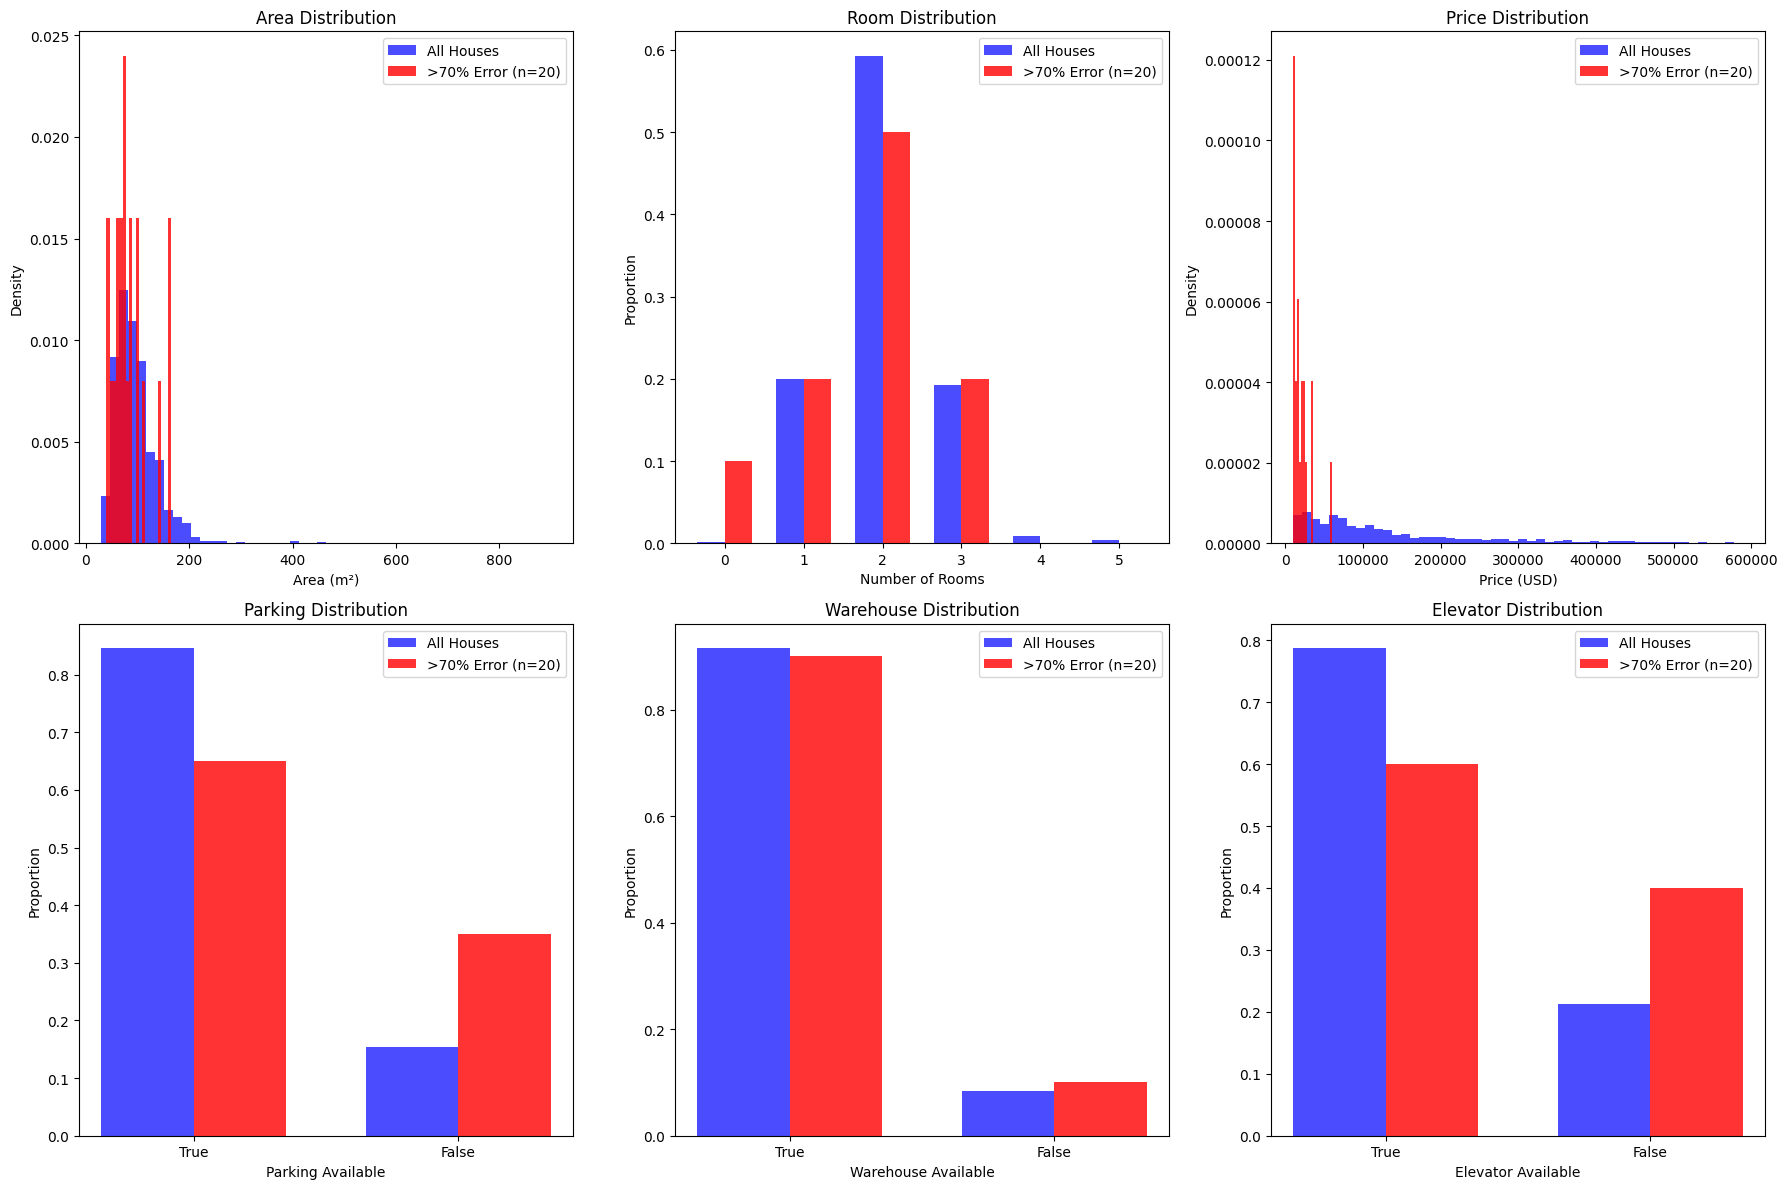


Statistical Summary for Houses with >70% Error:
Area - Mean: 84.9m², Median: 75.0m²
Price - Mean: $20,570, Median: $17,000
Rooms - Mode: 2
Parking - {True: 13, False: 7}
Warehouse - {True: 18, False: 2}
Elevator - {True: 12, False: 8}

Address Distribution for Houses with >70% Error:
--------------------------------------------------
Pakdasht: 4 houses
Parand: 2 houses
Persian Gulf Martyrs Lake: 2 houses
Amirabad: 1 houses
Kook: 1 houses
Nasim Shahr: 1 houses
Ostad Moein: 1 houses
Pardis: 1 houses
Pirouzi: 1 houses
Saadat Abad: 1 houses
Salehabad: 1 houses
Shahrake Qods: 1 houses
Si Metri Ji: 1 houses
Thirteen November: 1 houses
Vahidiyeh: 1 houses


In [19]:
# Identify predictions with error > 70%
very_high_error_mask = percentage_errors > 70
very_high_error_indices = np.where(very_high_error_mask)[0]

print(f"Predictions with error > 70%: {np.sum(very_high_error_mask)} ({np.sum(very_high_error_mask)/len(y_test)*100:.1f}%)")

if np.sum(very_high_error_mask) > 0:
    print(f"\nAll cases with >70% prediction error:")
    print("="*100)
    
    # Get original indices for high error cases
    original_indices = X_test.index[very_high_error_indices]
    
    # Print detailed information for each case
    for i, idx in enumerate(very_high_error_indices, 1):
        actual = y_test_original[idx]
        predicted = y_test_pred_original[idx]
        error = percentage_errors[idx]
        original_idx = original_indices[i-1]
        
        print(f"{i:2d}. Index: {original_idx} | Actual: ${actual:8,.0f} | Predicted: ${predicted:8,.0f} | Error: {error:5.1f}%")
        
        # Get original house features for this case
        house_features = houses.loc[original_idx]
        print(f"    Area: {house_features['Area']:.0f}m² | Rooms: {house_features['Room']} | "
              f"Parking: {house_features['Parking']} | Warehouse: {house_features['Warehouse']} | "
              f"Elevator: {house_features['Elevator']}")
        
        # Find the address (from one-hot encoded columns)
        address_cols = [col for col in houses.columns if col.startswith('Address_')]
        for addr_col in address_cols:
            if house_features[addr_col] == 1:
                address = addr_col.replace('Address_', '')
                print(f"    Address: {address}")
                break
        print()

    # Create histograms for houses with >70% error
    print("Creating histograms for houses with >70% prediction error...")
    
    # Get the original house data for high error cases
    high_error_houses = houses.loc[original_indices]
    
    # Create comparison histograms
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Area distribution
    ax1 = axes[0, 0]
    ax1.hist(houses['Area'], bins=50, alpha=0.7, color='blue', label='All Houses', density=True)
    ax1.hist(high_error_houses['Area'], bins=20, alpha=0.8, color='red', label=f'>70% Error (n={len(high_error_houses)})', density=True)
    ax1.set_xlabel('Area (m²)')
    ax1.set_ylabel('Density')
    ax1.set_title('Area Distribution')
    ax1.legend()
    
    # 2. Room distribution
    ax2 = axes[0, 1]
    room_counts_all = houses['Room'].value_counts().sort_index()
    room_counts_error = high_error_houses['Room'].value_counts().sort_index()
    
    x_pos = np.arange(len(room_counts_all))
    width = 0.35
    
    ax2.bar(x_pos - width/2, room_counts_all.values/len(houses), width, 
            alpha=0.7, color='blue', label='All Houses')
    
    # Align error data with all data
    error_values = []
    for room in room_counts_all.index:
        if room in room_counts_error.index:
            error_values.append(room_counts_error[room]/len(high_error_houses))
        else:
            error_values.append(0)
    
    ax2.bar(x_pos + width/2, error_values, width, 
            alpha=0.8, color='red', label=f'>70% Error (n={len(high_error_houses)})')
    
    ax2.set_xlabel('Number of Rooms')
    ax2.set_ylabel('Proportion')
    ax2.set_title('Room Distribution')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(room_counts_all.index)
    ax2.legend()
    
    # 3. Price distribution
    ax3 = axes[0, 2]
    ax3.hist(houses['Price'], bins=50, alpha=0.7, color='blue', label='All Houses', density=True)
    ax3.hist(high_error_houses['Price'], bins=20, alpha=0.8, color='red', label=f'>70% Error (n={len(high_error_houses)})', density=True)
    ax3.set_xlabel('Price (USD)')
    ax3.set_ylabel('Density')
    ax3.set_title('Price Distribution')
    ax3.legend()
    
    # 4. Parking distribution
    ax4 = axes[1, 0]
    parking_all = houses['Parking'].value_counts(normalize=True)
    parking_error = high_error_houses['Parking'].value_counts(normalize=True)
    
    x_pos = np.arange(len(parking_all))
    width = 0.35
    
    ax4.bar(x_pos - width/2, parking_all.values, width, 
            alpha=0.7, color='blue', label='All Houses')
    ax4.bar(x_pos + width/2, parking_error.reindex(parking_all.index, fill_value=0), width, 
            alpha=0.8, color='red', label=f'>70% Error (n={len(high_error_houses)})')
    
    ax4.set_xlabel('Parking Available')
    ax4.set_ylabel('Proportion')
    ax4.set_title('Parking Distribution')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(parking_all.index)
    ax4.legend()
    
    # 5. Warehouse distribution
    ax5 = axes[1, 1]
    warehouse_all = houses['Warehouse'].value_counts(normalize=True)
    warehouse_error = high_error_houses['Warehouse'].value_counts(normalize=True)
    
    x_pos = np.arange(len(warehouse_all))
    
    ax5.bar(x_pos - width/2, warehouse_all.values, width, 
            alpha=0.7, color='blue', label='All Houses')
    ax5.bar(x_pos + width/2, warehouse_error.reindex(warehouse_all.index, fill_value=0), width, 
            alpha=0.8, color='red', label=f'>70% Error (n={len(high_error_houses)})')
    
    ax5.set_xlabel('Warehouse Available')
    ax5.set_ylabel('Proportion')
    ax5.set_title('Warehouse Distribution')
    ax5.set_xticks(x_pos)
    ax5.set_xticklabels(warehouse_all.index)
    ax5.legend()
    
    # 6. Elevator distribution
    ax6 = axes[1, 2]
    elevator_all = houses['Elevator'].value_counts(normalize=True)
    elevator_error = high_error_houses['Elevator'].value_counts(normalize=True)
    
    x_pos = np.arange(len(elevator_all))
    
    ax6.bar(x_pos - width/2, elevator_all.values, width, 
            alpha=0.7, color='blue', label='All Houses')
    ax6.bar(x_pos + width/2, elevator_error.reindex(elevator_all.index, fill_value=0), width, 
            alpha=0.8, color='red', label=f'>70% Error (n={len(high_error_houses)})')
    
    ax6.set_xlabel('Elevator Available')
    ax6.set_ylabel('Proportion')
    ax6.set_title('Elevator Distribution')
    ax6.set_xticks(x_pos)
    ax6.set_xticklabels(elevator_all.index)
    ax6.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary for high error cases
    print("\nStatistical Summary for Houses with >70% Error:")
    print("="*60)
    print(f"Area - Mean: {high_error_houses['Area'].mean():.1f}m², Median: {high_error_houses['Area'].median():.1f}m²")
    print(f"Price - Mean: ${high_error_houses['Price'].mean():,.0f}, Median: ${high_error_houses['Price'].median():,.0f}")
    print(f"Rooms - Mode: {high_error_houses['Room'].mode().values[0] if len(high_error_houses['Room'].mode()) > 0 else 'N/A'}")
    print(f"Parking - {high_error_houses['Parking'].value_counts().to_dict()}")
    print(f"Warehouse - {high_error_houses['Warehouse'].value_counts().to_dict()}")
    print(f"Elevator - {high_error_houses['Elevator'].value_counts().to_dict()}")
    
    # Address distribution for high error cases
    print(f"\nAddress Distribution for Houses with >70% Error:")
    print("-"*50)
    address_cols = [col for col in high_error_houses.columns if col.startswith('Address_')]
    address_counts = {}
    for addr_col in address_cols:
        if high_error_houses[addr_col].sum() > 0:
            address_name = addr_col.replace('Address_', '')
            address_counts[address_name] = high_error_houses[addr_col].sum()
    
    for address, count in sorted(address_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{address}: {count} houses")

else:
    print("No predictions found with error > 70%")

In [20]:
import subprocess
import sys
import lime
import lime
import numpy as np
import pandas as pd

# Install LIME if not already installed

try:
    import lime.lime_tabular
except ImportError:
    print("Installing LIME...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lime"])
    import lime.lime_tabular


# Get the top 10 worst predictions
worst_indices = np.argsort(percentage_errors)[-10:][::-1]
original_indices = X_test.index[worst_indices]

print("LIME Analysis for Top 10 Worst Predictions")
print("=" * 60)

# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    mode='regression',
    discretize_continuous=True
)

# Function to group address features
def group_address_features(explanation_list):
    """Group address features and sum their contributions"""
    grouped = {}
    address_contribution = 0
    
    for feature, contribution in explanation_list:
        if feature.startswith('Address_'):
            address_contribution += contribution
        else:
            grouped[feature] = contribution
    
    if address_contribution != 0:
        grouped['Address'] = address_contribution
    
    return grouped

# Analyze each worst prediction
for i, idx in enumerate(worst_indices, 1):
    actual = y_test_original[idx]
    predicted = y_test_pred_original[idx]
    error = percentage_errors[idx]
    original_idx = original_indices[i-1]
    
    print(f"\n{i}. Case Index: {original_idx}")
    print(f"   Actual: ${actual:,.0f} | Predicted: ${predicted:,.0f} | Error: {error:.1f}%")
    
    # Get LIME explanation
    explanation = explainer.explain_instance(
        X_test.iloc[idx].values,
        best_rf_model.predict,
        num_features=len(X_test.columns)
    )
    
    # Get feature contributions
    feature_contributions = explanation.as_list()
    
    # Group address features
    grouped_contributions = group_address_features(feature_contributions)
    
    # Sort by absolute contribution
    sorted_contributions = sorted(grouped_contributions.items(), 
                                key=lambda x: abs(x[1]), reverse=True)
    
    # Show top contributing factors (positive and negative)
    print(f"   Top factors causing prediction error:")
    
    # Show top 5 most influential factors
    for feature, contribution in sorted_contributions[:5]:
        direction = "increases" if contribution > 0 else "decreases"
        print(f"     • {feature}: {direction} prediction by {abs(contribution):.4f}")
    
    # Get actual house features for context
    house_features = houses.loc[original_idx]
    print(f"   House details: {house_features['Area']:.0f}m², {house_features['Room']} rooms, "
          f"P:{house_features['Parking']}, W:{house_features['Warehouse']}, E:{house_features['Elevator']}")
    
    # Find address
    address_cols = [col for col in houses.columns if col.startswith('Address_')]
    for addr_col in address_cols:
        if house_features[addr_col] == 1:
            address = addr_col.replace('Address_', '')
            print(f"   Address: {address}")
            break

print(f"\nSummary: LIME analysis completed for top 10 worst predictions")
print("Key factors contributing to prediction errors identified above.")

LIME Analysis for Top 10 Worst Predictions

1. Case Index: 3425
   Actual: $10,500 | Predicted: $95,582 | Error: 810.3%


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


   Top factors causing prediction error:
     • Address: decreases prediction by 0.5210
     • Price_per_room <= 0.07: decreases prediction by 0.1033
     • Room <= 0.40: decreases prediction by 0.0554
     • 0.04 < Area <= 0.07: decreases prediction by 0.0291
     • Area_per_Room <= 0.05: decreases prediction by 0.0170
   House details: 75m², 2 rooms, P:True, W:True, E:True
   Address: Saadat Abad

2. Case Index: 3256
   Actual: $18,333 | Predicted: $85,825 | Error: 368.1%


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


   Top factors causing prediction error:
     • Address: decreases prediction by 1.0935
     • Price_per_room <= 0.07: decreases prediction by 0.1052
     • Room <= 0.40: decreases prediction by 0.0476
     • 0.04 < Area <= 0.07: decreases prediction by 0.0297
     • 0.05 < Area_per_Room <= 0.06: decreases prediction by 0.0167
   House details: 87m², 2 rooms, P:True, W:True, E:True
   Address: Amirabad

3. Case Index: 3397
   Actual: $12,000 | Predicted: $34,461 | Error: 187.2%


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


   Top factors causing prediction error:
     • Address: decreases prediction by 0.4183
     • Price_per_room <= 0.07: decreases prediction by 0.1049
     • Room <= 0.40: decreases prediction by 0.0521
     • Area <= 0.04: decreases prediction by 0.0390
     • Area_per_Room > 0.08: increases prediction by 0.0381
   House details: 43m², 0 rooms, P:False, W:True, E:False
   Address: Nasim Shahr

4. Case Index: 3335
   Actual: $14,500 | Predicted: $40,427 | Error: 178.8%


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


   Top factors causing prediction error:
     • Address: decreases prediction by 0.6594
     • Price_per_room <= 0.07: decreases prediction by 0.1034
     • Room <= 0.40: decreases prediction by 0.0525
     • 0.06 < Area_per_Room <= 0.08: decreases prediction by 0.0063
     • 0.07 < Area <= 0.10: decreases prediction by 0.0022
   House details: 100m², 2 rooms, P:True, W:True, E:True
   Address: Persian Gulf Martyrs Lake

5. Case Index: 3287
   Actual: $16,667 | Predicted: $44,388 | Error: 166.3%


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


   Top factors causing prediction error:
     • Address: decreases prediction by 1.5998
     • Price_per_room <= 0.07: decreases prediction by 0.1051
     • Room <= 0.40: decreases prediction by 0.0498
     • Area <= 0.04: decreases prediction by 0.0382
     • 0.05 < Area_per_Room <= 0.06: decreases prediction by 0.0118
   House details: 58m², 1 rooms, P:True, W:True, E:True
   Address: Pirouzi

6. Case Index: 3422
   Actual: $10,667 | Predicted: $27,240 | Error: 155.4%


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


   Top factors causing prediction error:
     • Address: decreases prediction by 1.5231
     • Price_per_room <= 0.07: decreases prediction by 0.1019
     • Room <= 0.40: decreases prediction by 0.0499
     • Area <= 0.04: decreases prediction by 0.0446
     • 0.06 < Area_per_Room <= 0.08: decreases prediction by 0.0022
   House details: 65m², 1 rooms, P:False, W:True, E:False
   Address: Pakdasht

7. Case Index: 3070
   Actual: $25,000 | Predicted: $55,936 | Error: 123.7%


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


   Top factors causing prediction error:
     • Address: decreases prediction by 0.7377
     • Price_per_room <= 0.07: decreases prediction by 0.1042
     • Room <= 0.40: decreases prediction by 0.0446
     • Area_per_Room > 0.08: increases prediction by 0.0401
     • 0.07 < Area <= 0.10: decreases prediction by 0.0004
   House details: 110m², 2 rooms, P:False, W:True, E:True
   Address: Salehabad

8. Case Index: 2879
   Actual: $32,667 | Predicted: $71,414 | Error: 118.6%


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


   Top factors causing prediction error:
     • Address: decreases prediction by 1.4897
     • Price_per_room <= 0.07: decreases prediction by 0.1058
     • Area > 0.10: increases prediction by 0.0703
     • Room > 0.40: increases prediction by 0.0488
     • Area_per_Room > 0.08: increases prediction by 0.0360
   House details: 160m², 3 rooms, P:True, W:True, E:True
   Address: Pakdasht

9. Case Index: 3289
   Actual: $16,667 | Predicted: $35,741 | Error: 114.4%


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


   Top factors causing prediction error:
     • Address: decreases prediction by 0.5339
     • Price_per_room <= 0.07: decreases prediction by 0.1055
     • Room > 0.40: increases prediction by 0.0474
     • Area_per_Room <= 0.05: decreases prediction by 0.0217
     • 0.07 < Area <= 0.10: decreases prediction by 0.0020
   House details: 100m², 3 rooms, P:True, W:True, E:True
   Address: Pardis

10. Case Index: 2398
   Actual: $59,733 | Predicted: $127,557 | Error: 113.5%
   Top factors causing prediction error:
     • Address: decreases prediction by 0.9738
     • Price_per_room <= 0.07: decreases prediction by 0.1001
     • Area > 0.10: increases prediction by 0.0770
     • Room > 0.40: increases prediction by 0.0479
     • 0.06 < Area_per_Room <= 0.08: decreases prediction by 0.0060
   House details: 140m², 3 rooms, P:True, W:True, E:True
   Address: Kook

Summary: LIME analysis completed for top 10 worst predictions
Key factors contributing to prediction errors identified above.


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Detailed Analysis of Locations with >70% Prediction Error
Total houses with >70% error: 20
Number of unique addresses affected: 15

Addresses with Most Prediction Errors (>70%):
--------------------------------------------------
Pakdasht                      :  4 houses (20.0%)
Parand                        :  2 houses (10.0%)
Persian Gulf Martyrs Lake     :  2 houses (10.0%)
Thirteen November             :  1 houses ( 5.0%)
Si Metri Ji                   :  1 houses ( 5.0%)
Pirouzi                       :  1 houses ( 5.0%)
Vahidiyeh                     :  1 houses ( 5.0%)
Kook                          :  1 houses ( 5.0%)
Nasim Shahr                   :  1 houses ( 5.0%)
Saadat Abad                   :  1 houses ( 5.0%)
Salehabad                     :  1 houses ( 5.0%)
Amirabad                      :  1 houses ( 5.0%)
Pardis                        :  1 houses ( 5.0%)
Ostad Moein                   :  1 houses ( 5.0%)
Shahrake Qods                 :  1 houses ( 5.0%)

Comparison with Tota

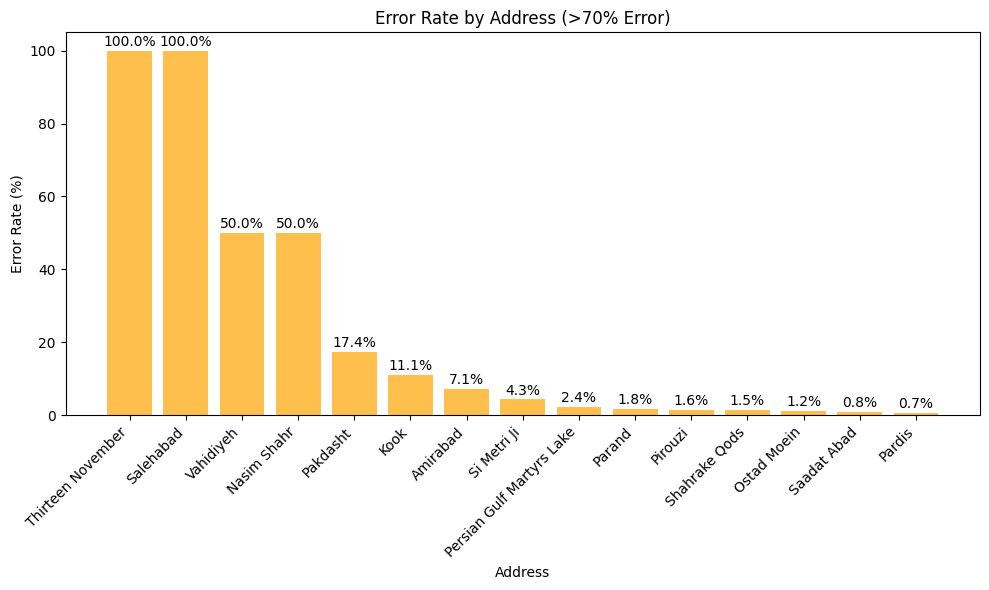


Summary Statistics:
Most problematic address: Thirteen November (100.0% error rate)
Address with most error cases: Pakdasht (4 houses)
Overall error rate for affected addresses: 2.7%


NameError: name 'addresses' is not defined

In [21]:
from collections import Counter

# Analyze locations with >70% prediction error in detail
print("Detailed Analysis of Locations with >70% Prediction Error")
print("=" * 70)

if np.sum(very_high_error_mask) > 0:
    # Get original indices for high error cases
    original_indices = X_test.index[very_high_error_indices]
    high_error_houses = houses.loc[original_indices]
    
    # Extract address information for high error cases
    address_cols = [col for col in houses.columns if col.startswith('Address_')]
    high_error_addresses = []
    
    for idx in original_indices:
        house_data = houses.loc[idx]
        for addr_col in address_cols:
            if house_data[addr_col] == 1:
                address = addr_col.replace('Address_', '')
                high_error_addresses.append(address)
                break
    
    # Count occurrences of each address in high error cases
    address_error_counts = Counter(high_error_addresses)
    
    print(f"Total houses with >70% error: {len(high_error_houses)}")
    print(f"Number of unique addresses affected: {len(address_error_counts)}")
    print()
    
    # Show address distribution
    print("Addresses with Most Prediction Errors (>70%):")
    print("-" * 50)
    for address, count in address_error_counts.most_common():
        percentage = count / len(high_error_houses) * 100
        print(f"{address:30s}: {count:2d} houses ({percentage:4.1f}%)")
    
    # Calculate total houses per address in entire dataset
    print(f"\nComparison with Total Houses per Address:")
    print("-" * 50)
    
    all_address_counts = {}
    for addr_col in address_cols:
        if houses[addr_col].sum() > 0:
            address_name = addr_col.replace('Address_', '')
            all_address_counts[address_name] = houses[addr_col].sum()
    
    # Calculate error rate for each address
    error_rates = {}
    for address in address_error_counts.keys():
        total_houses = all_address_counts.get(address, 0)
        error_count = address_error_counts[address]
        error_rate = (error_count / total_houses * 100) if total_houses > 0 else 0
        error_rates[address] = {
            'error_count': error_count,
            'total_houses': total_houses,
            'error_rate': error_rate
        }
    
    # Sort by error rate (highest first)
    sorted_error_rates = sorted(error_rates.items(), key=lambda x: x[1]['error_rate'], reverse=True)
    
    print("Address Error Analysis (sorted by error rate):")
    print(f"{'Address':<30} {'Error/Total':<12} {'Error Rate':<12} {'Avg Price':<15}")
    print("-" * 70)
    
    for address, stats in sorted_error_rates:
        # Calculate average price for this address
        address_col = f'Address_{address}'
        if address_col in houses.columns:
            address_houses = houses[houses[address_col] == 1]
            avg_price = address_houses['Price'].mean()
            
            print(f"{address:<30} {stats['error_count']:2d}/{stats['total_houses']:2d} ({stats['error_rate']:5.1f}%) ${avg_price:10,.0f}")
    
    # Create only the Error Rate visualization
    plt.figure(figsize=(10, 6))
    
    addresses_sorted = [addr for addr, _ in sorted_error_rates]
    error_rates_sorted = [stats['error_rate'] for _, stats in sorted_error_rates]
    
    bars = plt.bar(range(len(addresses_sorted)), error_rates_sorted, color='orange', alpha=0.7)
    plt.xlabel('Address')
    plt.ylabel('Error Rate (%)')
    plt.title('Error Rate by Address (>70% Error)')
    plt.xticks(range(len(addresses_sorted)), addresses_sorted, rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, rate in zip(bars, error_rates_sorted):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{rate:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\nSummary Statistics:")
    print("=" * 50)
    print(f"Most problematic address: {sorted_error_rates[0][0]} ({sorted_error_rates[0][1]['error_rate']:.1f}% error rate)")
    print(f"Address with most error cases: {address_error_counts.most_common(1)[0][0]} ({address_error_counts.most_common(1)[0][1]} houses)")
    
    # Calculate average error rate across all addresses with errors
    total_error_cases = sum(address_error_counts.values())
    total_houses_with_errors = sum(stats['total_houses'] for _, stats in error_rates.items())
    overall_error_rate = (total_error_cases / total_houses_with_errors * 100) if total_houses_with_errors > 0 else 0
    
    print(f"Overall error rate for affected addresses: {overall_error_rate:.1f}%")
    print(f"Average price in problematic addresses: ${np.mean([houses[houses[f'Address_{addr}'] == 1]['Price'].mean() for addr in addresses]):,.0f}")

else:
    print("No houses found with >70% prediction error")


In [ ]:
# Extract all unique addresses from the dataset
address_cols = [col for col in houses.columns if col.startswith('Address_')]
all_addresses = []

for addr_col in address_cols:
    address_name = addr_col.replace('Address_', '')
    all_addresses.append(address_name)

# Sort addresses alphabetically
all_addresses.sort()

print(f"Total number of unique addresses: {len(all_addresses)}")
print("\nAll addresses in the dataset:")
print("=" * 50)

for i, address in enumerate(all_addresses, 1):
    # Count houses in this address
    house_count = houses[f'Address_{address}'].sum()
    print(address)

# Summary statistics
print(f"\nSummary Statistics:")
print("=" * 50)
house_counts = [houses[f'Address_{addr}'].sum() for addr in all_addresses]
print(f"Average houses per address: {np.mean(house_counts):.1f}")
print(f"Median houses per address: {np.median(house_counts):.1f}")
print(f"Max houses in single address: {max(house_counts)}")
print(f"Min houses in single address: {min(house_counts)}")

# Show top 10 addresses with most houses
print(f"\nTop 10 addresses with most houses:")
print("-" * 40)
address_counts = [(addr, houses[f'Address_{addr}'].sum()) for addr in all_addresses]
address_counts.sort(key=lambda x: x[1], reverse=True)

for i, (address, count) in enumerate(address_counts[:10], 1):
    print(f"{i:2d}. {address:30s}: {count:3d} houses")

Total number of unique addresses: 189

All addresses in the dataset:
Abazar
Abbasabad
Absard
Abuzar
Afsarieh
Ahang
Air force
Ajudaniye
Alborz Complex
Aliabad South
Amir Bahador
Amirabad
Amirieh
Andisheh
Aqdasieh
Araj
Argentina
Atabak
Azadshahr
Azarbaijan
Azari
Baghestan
Bahar
Baqershahr
Beryanak
Boloorsazi
Central Janatabad
Chahardangeh
Chardangeh
Chardivari
Chidz
Damavand
Darabad
Darakeh
Darband
Daryan No
Dehkade Olampic
Dezashib
Dolatabad
Dorous
East Ferdows Boulevard
East Pars
Ekbatan
Ekhtiarieh
Elahieh
Elm-o-Sanat
Enghelab
Eram
Eskandari
Fallah
Farmanieh
Fatemi
Feiz Garden
Firoozkooh
Firoozkooh Kuhsar
Garden of Saba
Gheitarieh
Ghiyamdasht
Ghoba
Gholhak
Gisha
Golestan
Haft Tir
Hakimiyeh
Hashemi
Hassan Abad
Hekmat
Heravi
Heshmatieh
Hor Square
Islamshahr
Islamshahr Elahieh
Javadiyeh
Jeyhoon
Jordan
Kahrizak
Kamranieh
Karimkhan
Karoon
Kazemabad
Keshavarz Boulevard
Khademabad Garden
Khavaran
Komeil
Koohsar
Kook
Lavizan
Mahallati
Mahmoudieh
Majidieh
Marzdaran
Mehrabad
Mehrabad River River